# Coding 1 Home Assignment 1
### Authors: Mátyás Kovács & Márton Nagy

In this project we are going to analize the used cars market in Chicago. We would like to discover the patterns between the price and the age of a used car. For this analysis we will use linear and also non-linear models to find the best fit for our dataset. In the end of the analysis we are going to check the external validity of our best model(s) on Los Angeles, so we can decide if the patterns are the same in the two cities.

Let's import the necessary packages for the analysis.

In [1]:
import pandas as pd
import math
import numpy as np
from plotnine import *
import patchworklib as pw
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import display
from mizani.formatters import percent_format
import copy
from typing import List
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

First, we read the source datafile that was uploaded to Moodle. We downloaded the file and put it into our github repository so that the code will be reproducible without downloading the dataset and changing the code.

In [3]:
raw = pd.read_csv('https://raw.githubusercontent.com/marton-nagy-marton/Coding1_assignment1/refs/heads/main/used-cars.csv')
raw.head()

,pricestr,area,subarea,name,condition,cylinders,drive,fuel,odometer,paintcolor,...,dealer,price,lnprice,year,age,lnodometer,LE,XLE,SE,Hybrid
0,$4990,chicago,chicago city,2007 Toyota Camry Hybrid,good,4 cylinders,fwd,gas,11.6236,grey,...,1,4990,8.515191,2007,11,2.453038,0,0,0,1
1,$10625,chicago,chicago city,2009 Toyota Camry Hybrid,NaN,4 cylinders,fwd,hybrid,4.3702,grey,...,1,10625,9.270965,2009,9,1.474809,0,0,0,1
2,$14850,chicago,chicago city,2015 Toyota_ Camry_,excellent,other,NaN,gas,3.5721,NaN,...,1,14850,9.605755,2015,3,1.273154,0,0,0,0
3,$15630,chicago,chicago city,2016 TOYOTA CAMRY,NaN,NaN,fwd,gas,1.3152,NaN,...,1,15630,9.656947,2016,2,0.273989,0,0,0,0
4,$850,chicago,chicago city,1993 toyota camry,good,6 cylinders,fwd,gas,18.7000,red,...,0,850,6.745236,1993,25,2.928523,0,0,0,0


Next, we check the info on the raw data. We can see that while there are some missing values in certain variables, our variables of interest are complete.

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pricestr      549 non-null    object 
 1   area          549 non-null    object 
 2   subarea       540 non-null    object 
 3   name          549 non-null    object 
 4   condition     327 non-null    object 
 5   cylinders     360 non-null    object 
 6   drive         294 non-null    object 
 7   fuel          548 non-null    object 
 8   odometer      549 non-null    float64
 9   paintcolor    316 non-null    object 
 10  size          193 non-null    object 
 11  transmission  549 non-null    object 
 12  type          301 non-null    object 
 13  dealer        549 non-null    int64  
 14  price         549 non-null    int64  
 15  lnprice       549 non-null    float64
 16  year          549 non-null    int64  
 17  age           549 non-null    int64  
 18  lnodometer    549 non-null    

Just in case, we drop duplicate values (but actually, there are none).

In [7]:
raw.drop_duplicates(inplace=True)

We can now narrow down the dataframe to our variables of interest only, and then look at some summary statistics.

In [9]:
raw_f = raw.filter(['name', 'area', 'price', 'age'])
raw_f.describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,549.00,5866.15,5657.67,1.00,950.00,2400.00,4300.00,8299.00,14990.60,90002.00
age,549.00,12.18,5.89,1.00,3.00,8.00,12.00,16.00,21.00,27.00


We can see that price is in USD units. For better interpretation of the regression results later, we opt for converting it to thousands.

In [11]:
raw_f['price'] = raw_f['price'] / 1000
raw['price'] = raw['price'] / 1000

First, let's do some exploratory data analysis for the whole sample. For this, let's plot the distributions for price and age.

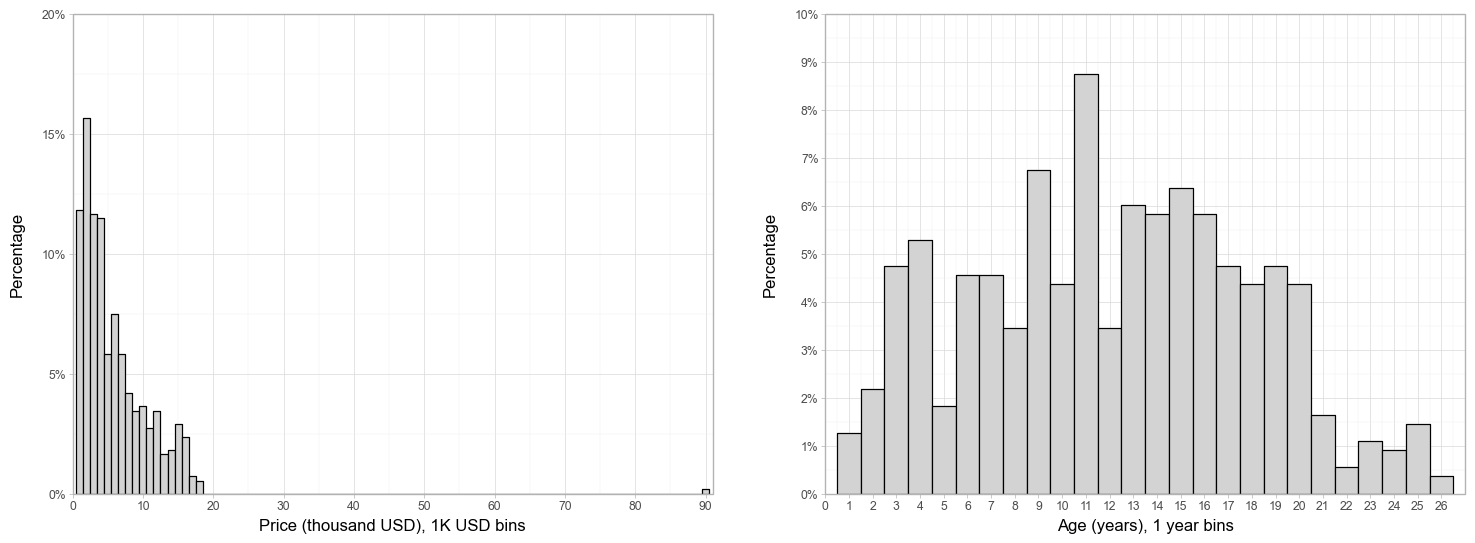

In [13]:
pw.basefigure.clear()
p1 = (
    ggplot(raw_f)
    + aes(x = 'price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 91),
        breaks=range(0, 91,10)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.2),
        breaks=np.arange(0,0.21,0.05),
        labels=percent_format()
    )
    + labs(
        x = 'Price (thousand USD), 1K USD bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(raw_f)
    + aes(x = 'age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 27),
        breaks=range(0, 27, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Age (years), 1 year bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

In the left chart we poltted the distribution of used car prices while in the right chart we put the distribution of the age of the used cars. Both histograms shows the relative frequency of the values. We shall also take a look at the log transformed distributions and summary statistics. We also compute the squared transformations, as we will later on need it in the regression analysis.

In [16]:
raw_f['ln_price'] = np.log(raw_f['price'])
raw_f['ln_age'] = np.log(raw_f['age'])
raw_f['age_sq'] = np.power(raw_f['age'],2)
raw_f['ln_age_sq'] = np.power(raw_f['ln_age'],2)

Let's look at the descriptive statistics of the log transformed variables, altough it is hard to interpret the values because of the transformation.

In [18]:
raw_f[['ln_price','ln_age']].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
ln_price,549.00,1.39,1.02,-6.91,-0.05,0.88,1.46,2.12,2.71,4.50
ln_age,549.00,2.34,0.65,0.00,1.10,2.08,2.48,2.77,3.04,3.30


We also check the distribution of the log transformed variables (in relative frequency).

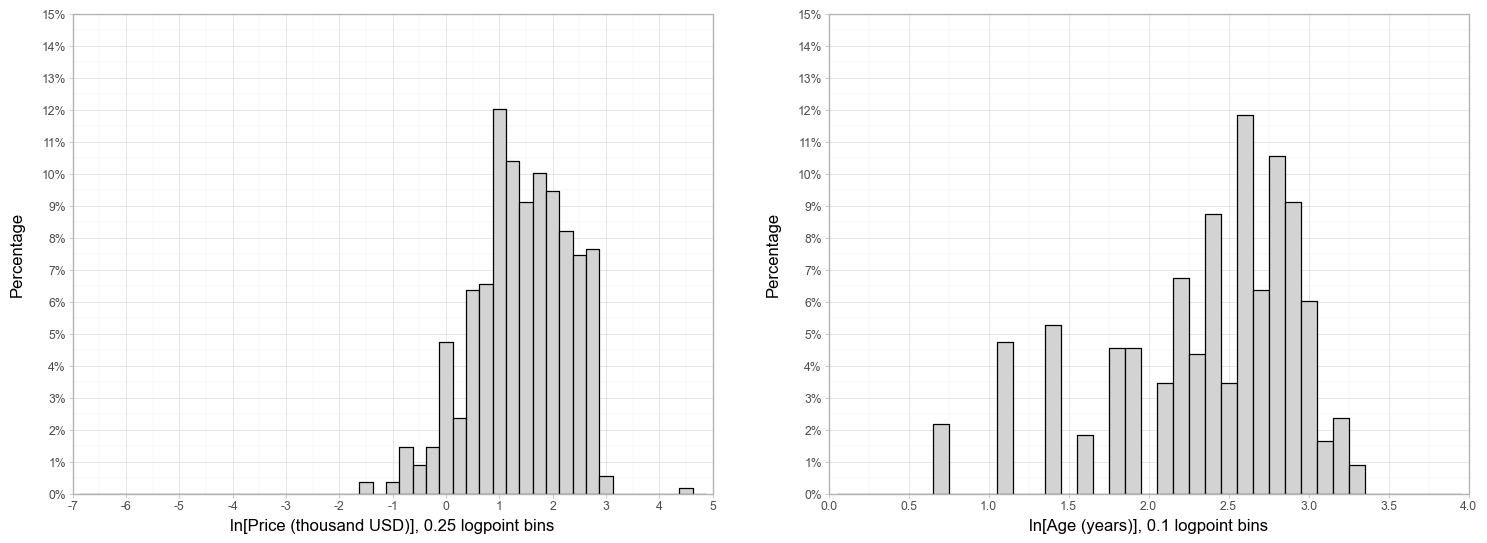

In [22]:
pw.basefigure.clear()
p1 = (
    ggplot(raw_f)
    + aes(x = 'ln_price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.25
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-7, 5),
        breaks=np.arange(-7, 5.1, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Price (thousand USD)], 0.25 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(raw_f)
    + aes(x = 'ln_age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 4),
        breaks=np.arange(0, 4.1, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Age (years)], 0.1 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

We can see that:
- for price, the initial distribution has a longer right tail, but a log transformation does not make it look completely normal (only closer to it),
- for age, the initial distribution is rather simmetric (there is not a big difference between the mean and the median), so there is no statistical reason to justify taking the log.

Next, we can create subsamples for the markets of the two cities in our dataset.

In [27]:
raw_f.area.unique()

array(['chicago', 'los angeles'], dtype=object)

In [29]:
chicago = raw_f[raw_f['area'] == 'chicago']
la = raw_f[raw_f['area'] == 'los angeles']

We would like to explore our Chicago subsample too, so we are going to do the same steps for this subsample as what we did for the whole dataset previously.

First let's check the descriptive statistics. Again, price is rather left skewed (with a long right tail), whereas age seems more or less symmetric.

In [31]:
chicago[['price', 'age']].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,327.00,5.96,4.52,0.21,0.88,2.30,4.40,8.97,14.99,18.50
age,327.00,12.19,5.98,1.00,3.00,7.00,12.00,17.00,21.00,27.00


If we take a look at the summary statistics of the log transformed variables as well, we can see that taking the log of price compresses the distribution to be closer to normal. For age, a log transformed variable is also rather symmetric as the initial one was rather symmetric as well.

In [37]:
chicago[['ln_price', 'ln_age']].describe(percentiles=[0.05,0.25, 0.5, 0.75, 0.95]).T.applymap(lambda x: format(x, '.2f'))

,count,mean,std,min,5%,25%,50%,75%,95%,max
ln_price,327.00,1.45,0.88,-1.58,-0.13,0.83,1.48,2.19,2.71,2.92
ln_age,327.00,2.33,0.65,0.00,1.10,1.95,2.48,2.83,3.04,3.30


Now let's create the histograms for our main variables and their log transformed versions as well.

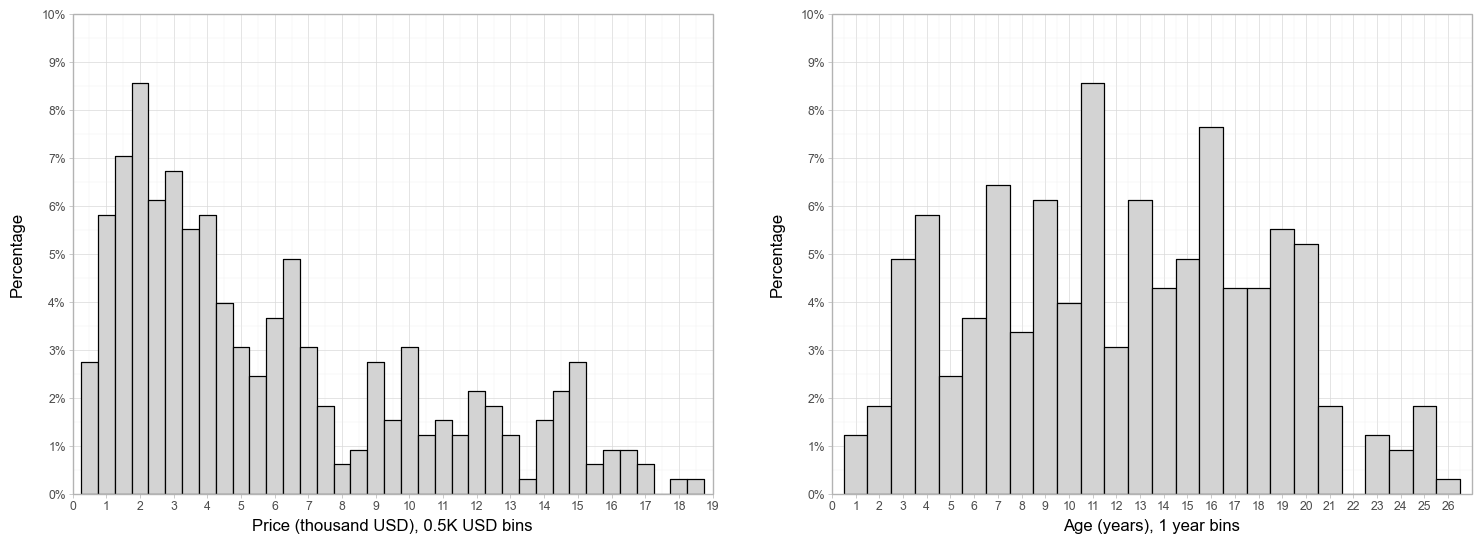

In [41]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.5
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 19),
        breaks=range(0, 20,1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Price (thousand USD), 0.5K USD bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(chicago)
    + aes(x = 'age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 27),
        breaks=range(0, 27, 1)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.1),
        breaks=np.arange(0,0.11,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'Age (years), 1 year bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

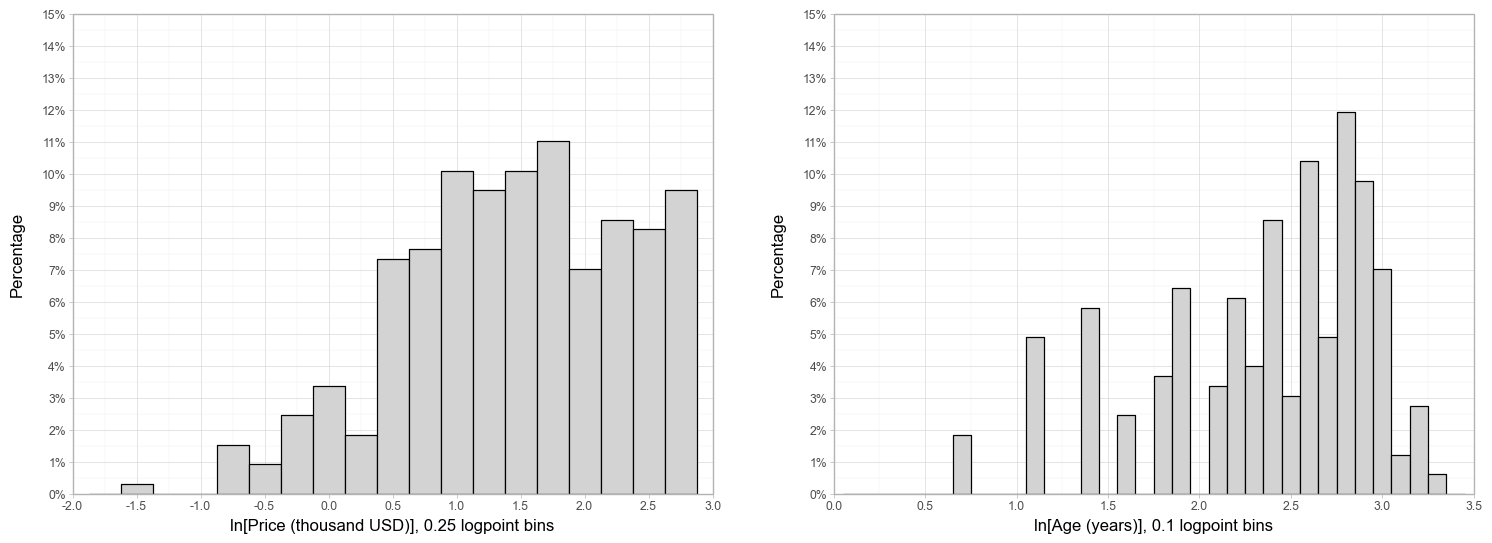

In [43]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'ln_price')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.25
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(-2, 3),
        breaks=np.arange(-2, 3.1, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Price (thousand USD)], 0.25 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p2 = (
    ggplot(chicago)
    + aes(x = 'ln_age')
    + geom_histogram(
        aes(y=after_stat("count / np.sum(count)")),
        fill = 'lightgrey', 
        color = 'black', 
        binwidth = 0.1
    )
    + scale_x_continuous(
        expand=(0, 0),
        limits=(0, 3.5),
        breaks=np.arange(0, 3.51, 0.5)
    )
    + scale_y_continuous(
        expand=(0, 0),
        limits = (0,0.15),
        breaks=np.arange(0,0.16,0.01),
        labels=percent_format()
    )
    + labs(
        x = 'ln[Age (years)], 0.1 logpoint bins',
        y = 'Percentage'
    )
    + theme_light()
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
combined = p1|p2
combined.savefig()

To understand our subsample further, let's create a scatter plot of price versus age.

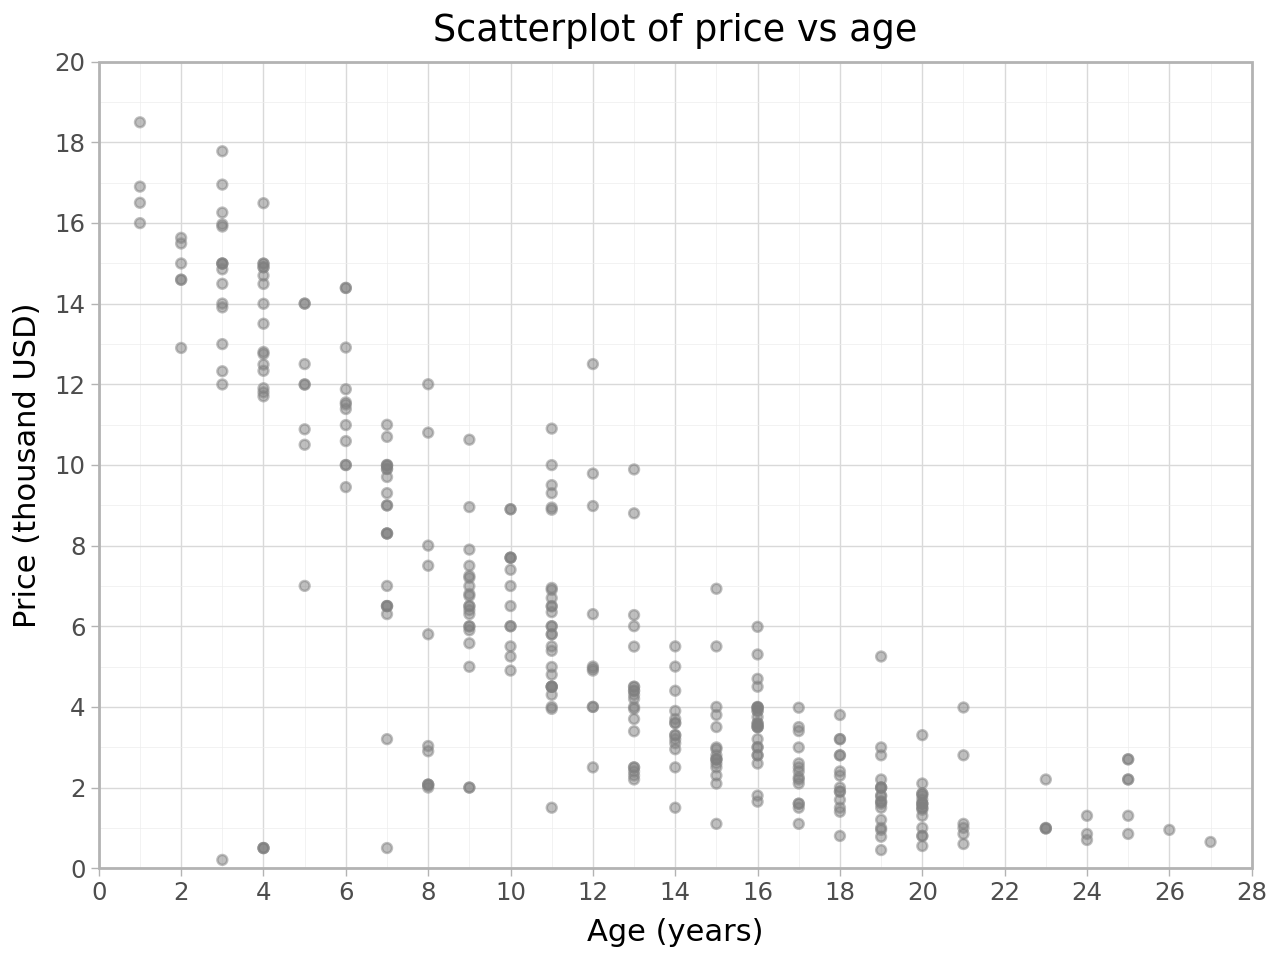

In [49]:
(
    ggplot(chicago)
    + aes(x = 'age', y = 'price')
    + geom_point(color = 'grey', alpha = 0.5)
    + theme_light()
    + scale_x_continuous(expand=(0, 0),
                         limits=(0, 28),
                         breaks=np.arange(0,29,2)
                        )
    + scale_y_continuous(expand=(0, 0),
                         limits = (0,20),
                         breaks=np.arange(0,21,2)
                        )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Scatterplot of price vs age')
)

From the above histograms, but more importantly from the scatterplot, we can see that there are a small number of observations that do not fit into the pattern at all, in the lower left corner. These would be quite influential observations, so we shall carefully decide whether it makes sense to include or exclude them from the analysis.

We should inspect these elements in detail to decide whether they are sensible observations or possible errors. From the below table, we can confidently conclude that these observations are rather an error, as there is no characteristic for these cars that would reasonably justify the low price compared to the young age. So, we should drop these observations from further analysis.

In [51]:
raw[(raw['age'] < 10) & (raw['price'] < 1 & (raw['area'] == 'chicago'))].T

,129,149,150,269,335
pricestr,$500,$500,$206,$500,$500
area,chicago,chicago,chicago,chicago,chicago
subarea,chicago city,chicago city,chicago city,chicago city,chicago city
name,2011 toyota camry xle,2014 TOYOTA CAMRY LE 2.4,2015 Toyota Camry BAD CREDIT OK,2014 TOYOTA CAMRY,2014 TOYOTA CAMRY
condition,NaN,excellent,NaN,like new,like new
cylinders,NaN,6 cylinders,4 cylinders,6 cylinders,4 cylinders
drive,NaN,fwd,NaN,fwd,fwd
fuel,gas,gas,gas,gas,gas
odometer,10.323048,4.791687,4.963213,4.791687,4.791687
paintcolor,NaN,black,grey,black,black


In [53]:
chicago = (chicago[~((chicago['age'] < 10) & (chicago['price'] < 1))])

Now we can plot some lowess estimates in all possible log-transformation specification.

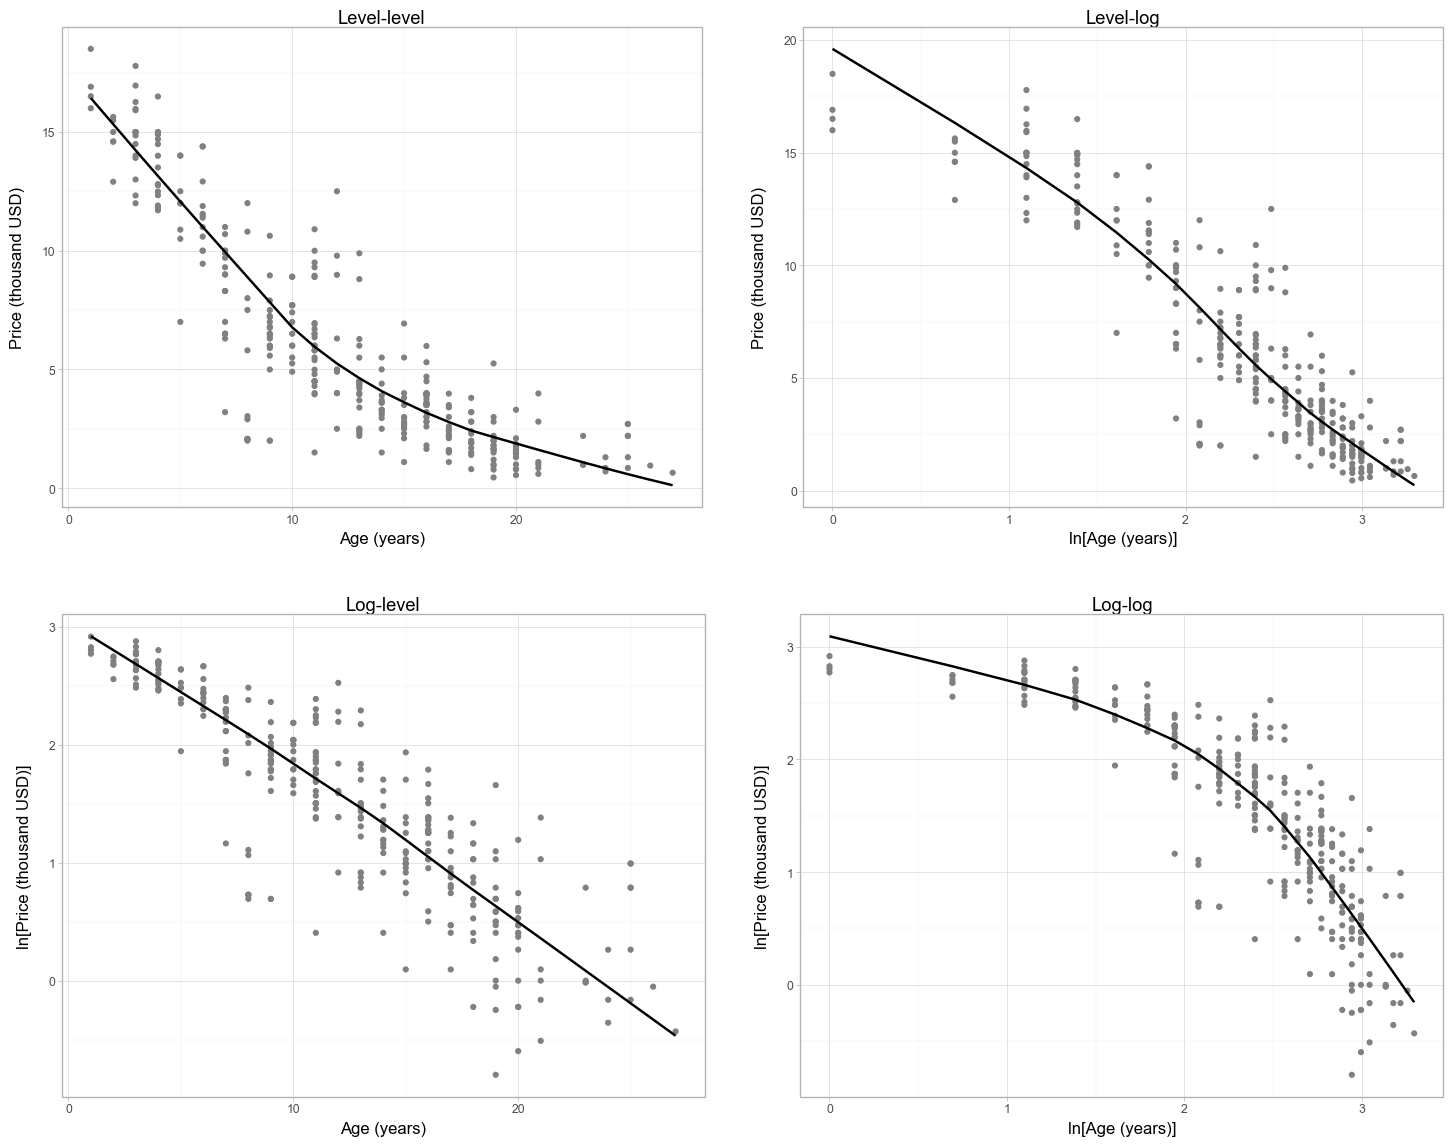

In [65]:
pw.basefigure.clear()
p1 = (
    ggplot(chicago)
    + aes(x = 'age', y = 'price')
    + geom_point(color = 'grey')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'Age (years)',
        y = 'Price (thousand USD)',
        title = 'Level-level'
    )
)

p2 = (
    ggplot(chicago)
    + aes(x = 'ln_age', y = 'price')
    + geom_point(color = 'grey')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'ln[Age (years)]',
        y = 'Price (thousand USD)',
        title = 'Level-log'
    )
)

p3 = (
    ggplot(chicago)
    + aes(x = 'age', y = 'ln_price')
    + geom_point(color = 'grey')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'Age (years)',
        y = 'ln[Price (thousand USD)]',
        title = 'Log-level'
    )
)

p4 = (
    ggplot(chicago)
    + aes(x = 'ln_age', y = 'ln_price')
    + geom_point(color = 'grey')
    + geom_smooth(method = 'lowess')
    + theme_light()
    + labs(
        x = 'ln[Age (years)]',
        y = 'ln[Price (thousand USD)]',
        title = 'Log-log'
    )
)

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)
p4 = pw.load_ggplot(p4)

combined = (p1|p2)/(p3|p4)
combined.savefig()

In the next steps we are going to build some models in order to find the one which describes our dataset the most. We will use linear and also non-linear models, some of which will be the Piecewise Lienar Spline (PLS). In order to create models with PLS, fist we have to define a function for that.

Note that the PLS function itself is not our own work, as it has been re-used from the notebook provided in class.

In [70]:
def knot_ceil(vector: np.array, knot: float) -> np.array:
    """
    Apply a ceiling value to elements in a numpy array.

    This function takes a numpy array and a ceiling value (knot). It returns a copy of the array where all elements greater than the ceiling value are replaced by the ceiling value.

    Parameters:
    vector (np.array): The input numpy array.
    knot (float): The ceiling value to apply.

    Returns:
    np.array: A new numpy array with elements capped at the ceiling value.
    
    Example:
    >>> import numpy as np
    >>> vector = np.array([1, 2, 3, 4, 5])
    >>> knot = 3
    >>> knot_ceil(vector, knot)
    array([1, 2, 3, 3, 3])
    """
    
    vector_copy = copy.deepcopy(vector)
    # vector_copy = vector.copy()
    vector_copy[vector_copy > knot] = knot
    return vector_copy


def lspline(series: pd.Series, knots: List[float]) -> np.array:
    """
    Generate a linear spline basis matrix for a given pandas Series and knots.

    This function creates a design matrix for linear splines based on the provided knots. 
    It iteratively applies a ceiling function to the series values at each knot, 
    subtracting the resulting column from the series to prepare for the next knot.

    Parameters:
    series (pd.Series): The input pandas Series.
    knots (List[float]): A list of knot values where the spline should change slope.

    Returns:
    np.array: A design matrix where each column corresponds to a segment of the linear spline.

    Example:
    >>> import pandas as pd
    >>> series = pd.Series([1, 2, 3, 4, 5])
    >>> knots = [2, 4]
    >>> lspline(series, knots)
    array([[1, 0, 0],
           [2, 0, 0],
           [2, 1, 0],
           [2, 2, 0],
           [2, 2, 1]])
    """
    
    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])

        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))

        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))

    return design_matrix

Next, we calculate 12 regressions, 4 simple linear, 4 quadratic and 4 PLS ones. Each type of regression is estimated in all possible log-transformation specification. PLS models are estimated with knots at 10 and 15 years, a choice based on the lowess estimates. We use robust standard errors (HC0).

In [72]:
regs = []
regs.append(smf.ols(formula='price~age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~ln_age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~ln_age',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~age+age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~ln_age+ln_age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~age+age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~ln_age+ln_age_sq',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~lspline(age,[10,15])',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='price~lspline(ln_age,[np.log(10),np.log(15)])',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~lspline(age,[10,15])',data=chicago).fit(cov_type = 'HC0'))
regs.append(smf.ols(formula='ln_price~lspline(ln_age,[np.log(10),np.log(15)])',data=chicago).fit(cov_type = 'HC0'))

Let's put all of our resault in one table to compare them.

In [74]:
table = Stargazer(regs)
table.custom_columns(['Level-level','Level-log','Log-level','Log-log',
                      'Level-level Quadratic','Level-log Quadratic','Log-level Quadratic','Log-log Quadratic',
                      'Level-level PLS','Level-log PLS','Log-level PLS', 'Log-log PLS'
                     ])
table.rename_covariates(
    {
        'Intercept' : 'Constant',
        'age_sq' : 'age squared',
        'ln_age' : 'ln(age)',
        'ln_age_sq' : 'ln(age) squared',
        'lspline(age, [10, 15])[0]': 'age spline < 10',
        'lspline(age, [10, 15])[1]' : 'age spline 10-15',
        'lspline(age, [10, 15])[2]' : 'age spline > 15',
        'lspline(ln_age, [np.log(10), np.log(15)])[0]': 'ln(age) spline < ln(10)',
        'lspline(ln_age, [np.log(10), np.log(15)])[1]' : 'ln(age) spline ln(10)-ln(15)',
        'lspline(ln_age, [np.log(10), np.log(15)])[2]' : 'ln(age) spline > ln(15)',       
    }
)
table.add_custom_notes(['Heteroscedasticity corrected standard errors used (HC0).'])
table

We extract the predicted values from the regressions, and transform it back to level price if needed. We also add a lowess estimate. To directly compare the explanatory power of models with ln(price) and price as the dependent variable, we also calculate the pseudo R2 on the level-transformed predicted values.

In [76]:
columns = [
    'Level-level', 'Level-log', 'Log-level', 'Log-log',
    'Level-level Quadratic', 'Level-log Quadratic', 'Log-level Quadratic', 'Log-log Quadratic',
    'Level-level PLS', 'Level-log PLS', 'Log-level PLS', 'Log-log PLS'
]

pred_dict = {}
pred_dict['age'] = list(chicago['age'])

y = chicago['price']
y_mean = np.mean(y)
ss_total = np.sum((y - y_mean) ** 2)

pseudo_r2 = {}

for i, reg in enumerate(regs):
    if 'Log-' in columns[i]:
        residual_variance = np.var(reg.resid)
        predictions = [np.exp(x) * np.exp(residual_variance / 2) for x in reg.get_prediction().summary_frame()['mean']]
    else:
        predictions = reg.get_prediction().summary_frame()['mean']
    pred_dict[columns[i]] = predictions
    ss_residual = np.sum((y - predictions) ** 2)
    pseudo_r2[columns[i]] = round(1 - (ss_residual / ss_total),4)

pred_df = pd.DataFrame(pred_dict)

pred_df['Lowess'] = list(sm.nonparametric.lowess(y, chicago['age'], frac=0.66, return_sorted=False))
#the frac=0.66 in the lowess estimate is there so that we get back the exact same estimate that was initially plotted


In [78]:
pred_df

,age,Level-level,Level-log,Log-level,Log-log,Level-level Quadratic,Level-log Quadratic,Log-level Quadratic,Log-log Quadratic,Level-level PLS,Level-log PLS,Log-level PLS,Log-log PLS,Lowess
0,11,6.908388,5.733721,5.665835,4.713593,5.776793,5.970382,5.549517,5.362733,5.373081,5.950747,5.646366,5.989888,5.927224
1,9,8.217207,7.005338,7.243823,5.839508,7.439467,7.327645,7.140625,7.036326,7.069469,7.371299,7.256081,7.517290,7.695648
2,3,12.143665,13.967061,15.138380,18.864964,14.082927,13.849566,15.673708,16.926968,14.227624,13.819427,15.274554,14.569270,14.365547
3,2,12.798075,16.536426,17.117146,29.081445,15.431589,15.868381,17.946197,18.040514,15.420650,16.199239,17.292042,18.599441,15.513846
4,25,-2.253348,0.531304,1.014698,1.962335,1.863469,-0.116384,1.092746,1.234051,0.722208,0.873262,1.051247,1.100607,0.721141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,2,12.798075,16.536426,17.117146,29.081445,15.431589,15.868381,17.946197,18.040514,15.420650,16.199239,17.292042,18.599441,15.513846
331,15,4.290749,3.768321,3.466221,3.385124,3.279167,3.771747,3.402431,3.293848,3.359633,3.340403,3.400538,3.516458,3.500189
332,18,2.327520,2.612980,2.397731,2.786484,2.130202,2.422142,2.388494,2.380270,2.568405,2.459842,2.391084,2.323010,2.382097
333,8,8.871617,7.751709,8.190676,6.621807,8.374268,8.100409,8.115005,8.121385,8.262495,8.062608,8.214475,8.069956,8.736938


From the pseudo-R2 values, we can see that most of our models describe our dataset well, because the pseudo-R2 value is usually above 0.7 which means that the models explain more than 75% of the variation in level price. Out of these models the best fitting ones are the level-level quadratic and the level-level PLS ones, both scoring slightly above an R-squared of 83%.

In [88]:
pseudo_r2

{'Level-level': 0.7447,
 'Level-log': 0.819,
 'Log-level': 0.8311,
 'Log-log': -0.5951,
 'Level-level Quadratic': 0.8336,
 'Level-log Quadratic': 0.8256,
 'Log-level Quadratic': 0.8213,
 'Log-log Quadratic': 0.8095,
 'Level-level PLS': 0.8324,
 'Level-log PLS': 0.8224,
 'Log-level PLS': 0.829,
 'Log-log PLS': 0.7408}

We can now plot the estimated prices from the regressions. For better visibility, we plot separate charts for each model type.

In [93]:
pw.basefigure.clear()
p1 = (
    ggplot(pred_df.melt(id_vars='age').query("~variable.str.contains('PLS|Quadratic')", engine='python'))
    #+ aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'grey',
        alpha = 0.25
    )
    + geom_line(aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable'), size = 1)
    + scale_color_manual(
        values=['#9AC4F8', '#F49097', '#419D78', '#ECC30B', '#1C3144'],
        labels=['Level-level','Level-log','Log-level','Log-log','Lowess']
    )
    + scale_linetype_manual(
        values=['--', (0, (1, 1)), ':', '-.', '-'],
        labels=['Level-level','Level-log','Log-level','Log-log','Lowess']
    )
    + scale_x_continuous(expand=(0, 0),
                         limits=(0, 28),
                         breaks=np.arange(0,29,2)
                        )
    + scale_y_continuous(expand=(0, 0),
                         limits = (0,65),
                         breaks=np.arange(0,66,5)
                        )
    + theme_light()
    + theme(
        legend_position=(0.85, 0.85),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Simple linear models')
)

p2 = (
    ggplot(pred_df.melt(id_vars='age').query("variable.str.contains('Quadratic|Lowess')", engine='python'))
    #+ aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'grey',
        alpha = 0.25
    )
    + geom_line(aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable'), size = 1)
    + scale_color_manual(
        values=['#9AC4F8', '#F49097', '#419D78', '#ECC30B', '#1C3144'],
        labels=['Level-level','Level-log','Log-level','Log-log','Lowess']
    )
    + scale_linetype_manual(
        values=['--', (0, (1, 1)), ':', '-.', '-'],
        labels=['Level-level','Level-log','Log-level','Log-log','Lowess']
    )
    + scale_x_continuous(expand=(0, 0),
                         limits=(0, 28),
                         breaks=np.arange(0,29,2)
                        )
    + scale_y_continuous(expand=(0, 0),
                         limits = (0,25),
                         breaks=np.arange(0,26,5)
                        )
    + theme_light()
    + theme(
        legend_position=(0.85, 0.85),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Quadratic models')
)

p3 = (
    ggplot(pred_df.melt(id_vars='age').query("variable.str.contains('PLS|Lowess')", engine='python'))
    #+ aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'grey',
        alpha = 0.25
    )
    + geom_line(aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable'), size = 1)
    + scale_color_manual(
        values=['#9AC4F8', '#F49097', '#419D78', '#ECC30B', '#1C3144'],
        labels=['Level-level','Level-log','Log-level','Log-log','Lowess']
    )
    + scale_linetype_manual(
        values=['--', (0, (1, 1)), ':', '-.', '-'],
        labels=['Level-level','Level-log','Log-level','Log-log','Lowess']
    )
    + scale_x_continuous(expand=(0, 0),
                         limits=(0, 28),
                         breaks=np.arange(0,29,2)
                        )
    + scale_y_continuous(expand=(0, 0),
                         limits = (0,25),
                         breaks=np.arange(0,26,5)
                        )
    + theme_light()
    + theme(
        legend_position=(0.85, 0.85),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'PLS models')
)

p4 = ggplot(chicago)+theme_void()

In [95]:
p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)
p4 = pw.load_ggplot(p4)

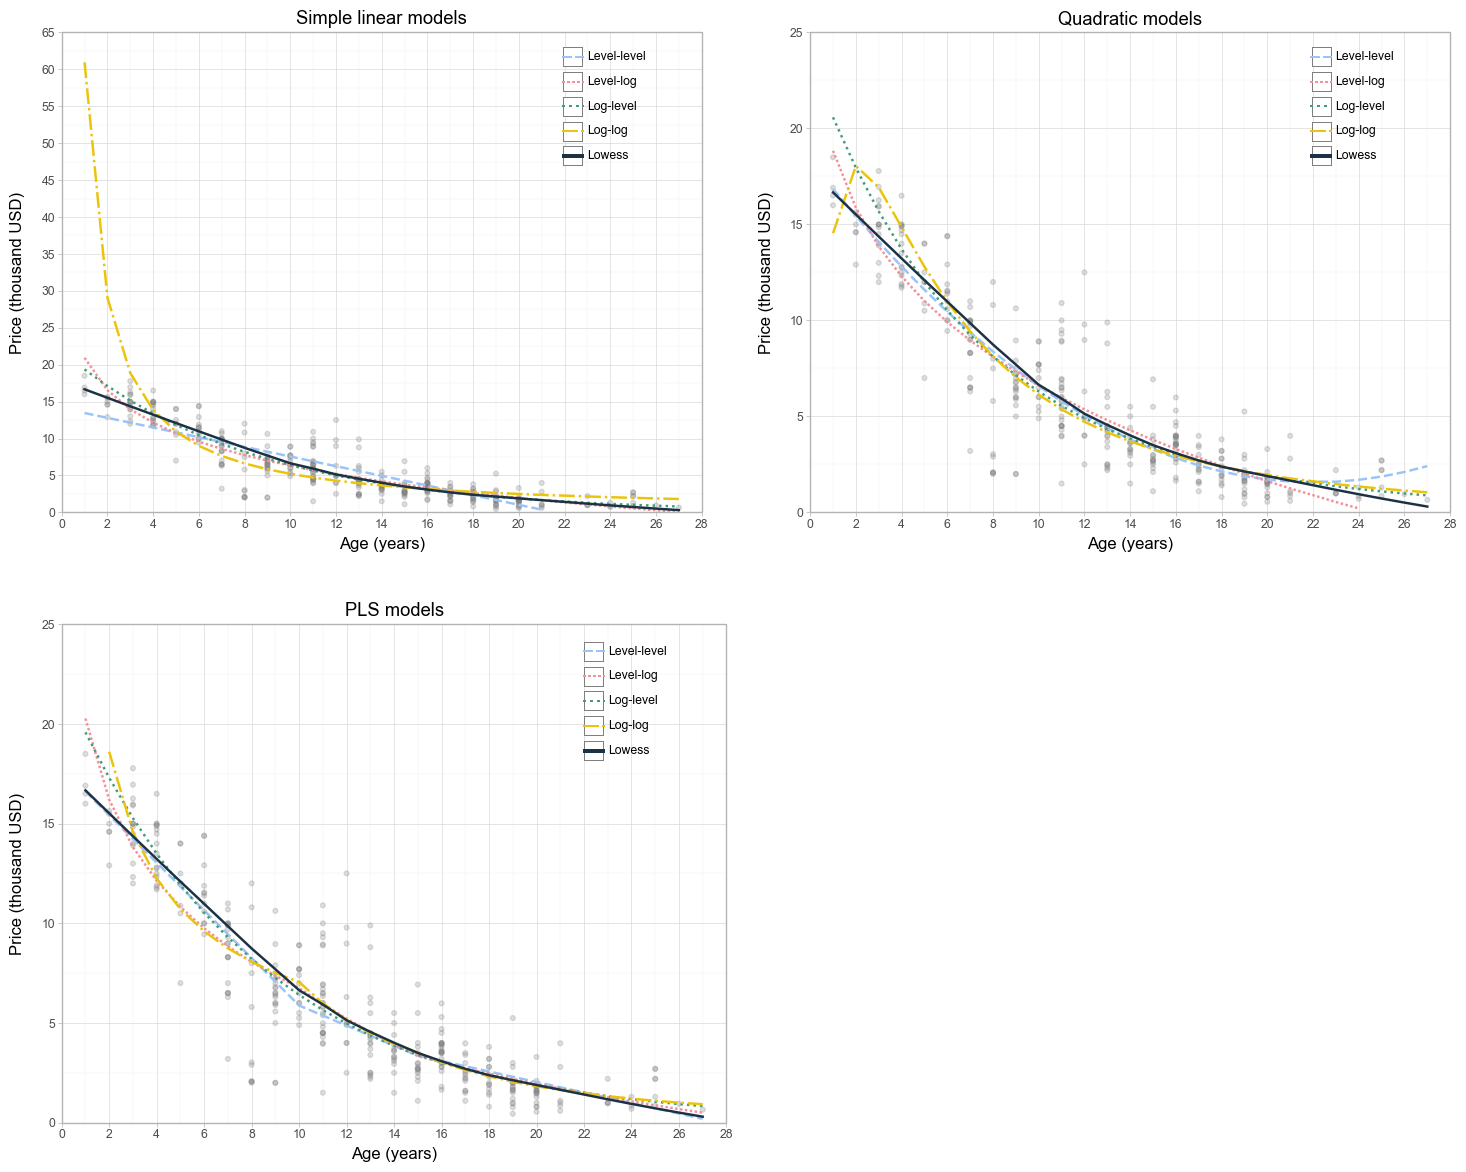

In [96]:
combined = (p1|p2)/(p3|p4)
combined.savefig()

In the plots we can also see that most of our models fit the dataset quite well. One of the notable exceptions are the regressions with log-log variables. Their weak performace stems from the fact that their predictions are very much off for cars between age 0 to 4.

We can also plot the best fitting two models only (that is, as mentioned above, the level-level quadratic and the level-level PLS models), along with the lowess estimate.

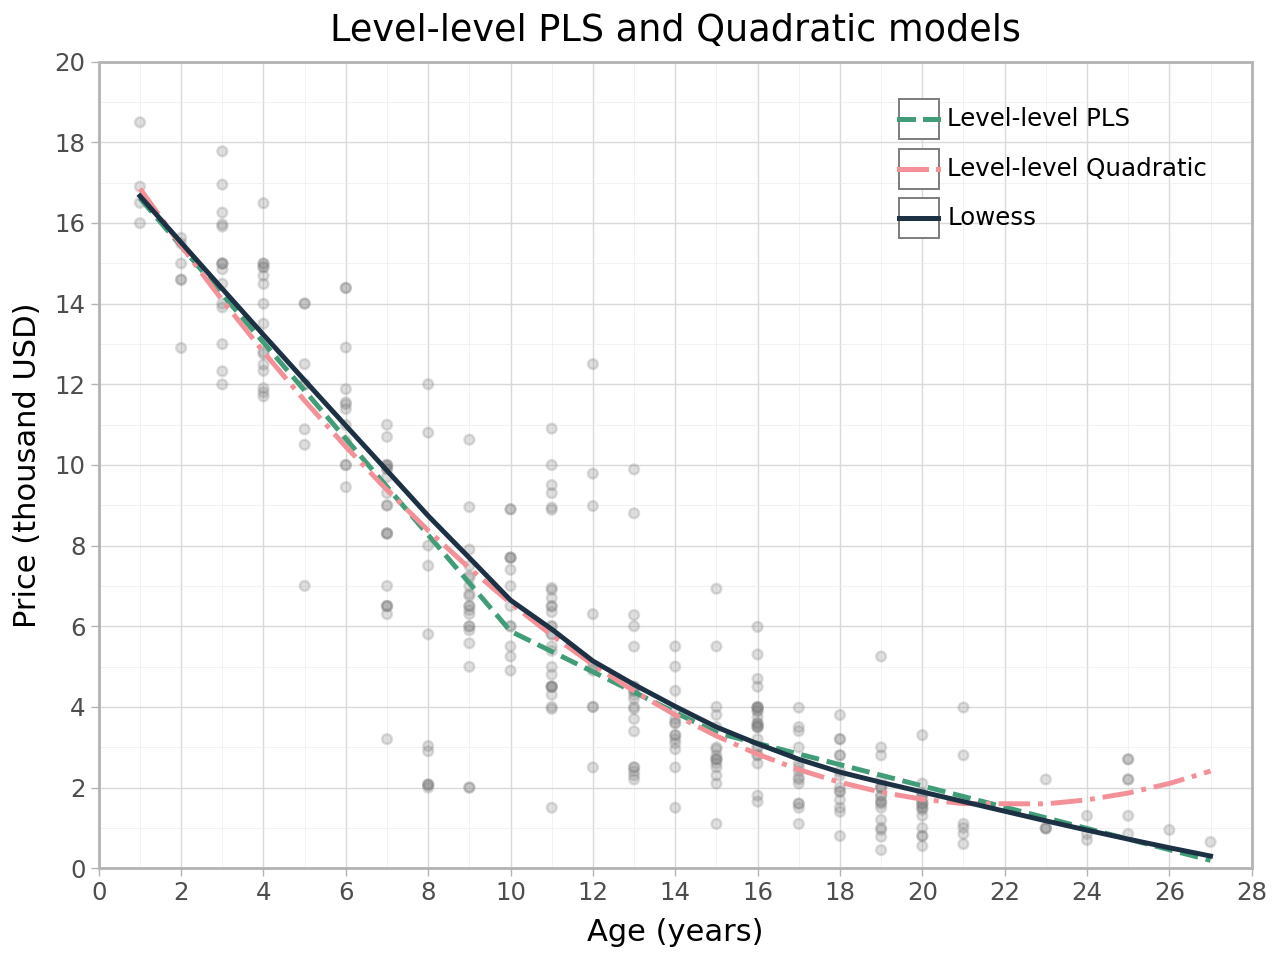

In [132]:
(
    ggplot(pred_df.melt(id_vars='age').query("variable.str.contains('Level-level PLS|Level-level Quadratic|Lowess')"))
    #+ aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable')
    + geom_point(
        aes(x = 'age', y = 'price'),
        data = chicago,
        color = 'grey',
        alpha = 0.25
    )
    + geom_line(aes(x = 'age', y = 'value', color = 'variable', linetype = 'variable'), size = 1)
    + scale_color_manual(
        values=['#419D78', '#F49097', '#1C3144'],
        labels=['Level-level PLS','Level-level Quadratic', 'Lowess']
    )
    + scale_linetype_manual(
        values=['--', '-.', '-'],
        labels=['Level-level PLS','Level-level Quadratic', 'Lowess']
    )
    + scale_x_continuous(expand=(0, 0),
                         limits=(0, 28),
                         breaks=np.arange(0,29,2)
                        )
    + scale_y_continuous(expand=(0, 0),
                         limits = (0,20),
                         breaks=np.arange(0,21,2)
                        )
    + theme_light()
    + theme(
        legend_position=(0.95, 0.95),
        legend_title=element_blank(),
        legend_background=element_blank(),
    )
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Level-level PLS and Quadratic models')
)

We can also add a confidence interval.

In [104]:
df_ci = pd.DataFrame({
    'age' : pred_dict['age'],
    'lowess' : list(pred_df['Lowess']),
    'pls' : list(regs[8].get_prediction().summary_frame()['mean']),
    'pls_ciup' : list(regs[8].get_prediction().summary_frame()['mean_ci_upper']),
    'pls_cilo' : list(regs[8].get_prediction().summary_frame()['mean_ci_lower']),
    'quadratic': list(regs[4].get_prediction().summary_frame()['mean']),
    'quadratic_ciup' : list(regs[4].get_prediction().summary_frame()['mean_ci_upper']),
    'quadratic_cilo' : list(regs[4].get_prediction().summary_frame()['mean_ci_lower']),
})

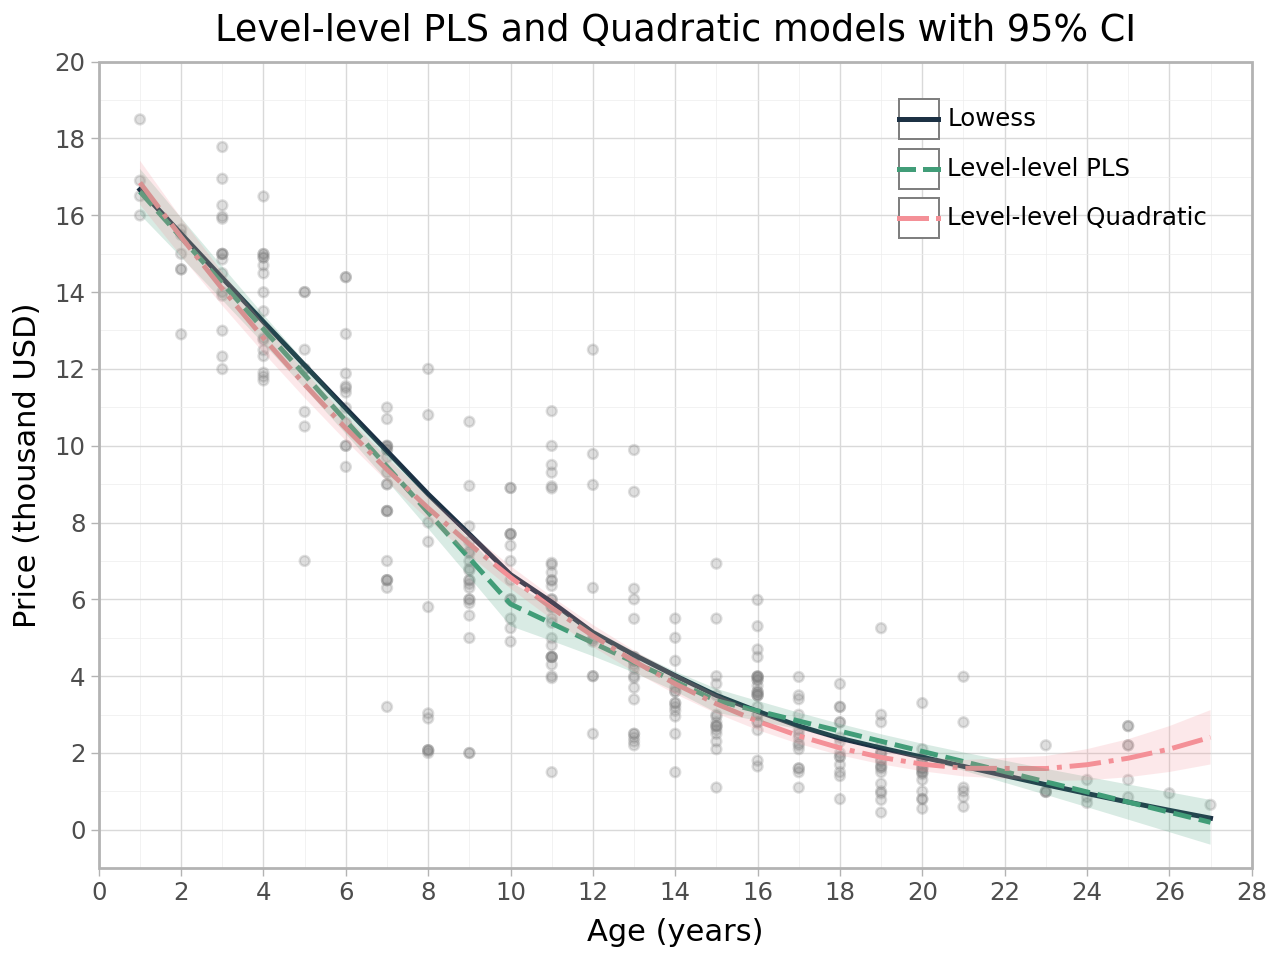

In [138]:
(
    ggplot(df_ci.melt(id_vars='age', value_vars=['lowess', 'pls', 'quadratic'])
          .rename(columns={'variable': 'model', 'value': 'price'}))
    + geom_point(
        aes(x='age', y='price'),
        data=chicago,
        color='grey',
        alpha=0.25
    )
    + geom_line(aes(x='age', y='price', color='model', linetype='model'),size=1)
    + geom_ribbon(
        aes(ymin='pls_cilo', ymax='pls_ciup', x = 'age'),
        data = df_ci,
        fill='#419D78',
        alpha=0.2,
    )
    + geom_ribbon(
        aes(ymin='quadratic_cilo', ymax='quadratic_ciup', x = 'age'),
        data = df_ci,
        fill='#F49097',
        alpha=0.2,
    )
    + scale_color_manual(
        values=['#1C3144', '#419D78', '#F49097'],
        labels=['Lowess', 'Level-level PLS', 'Level-level Quadratic']
    )
    + scale_linetype_manual(
        values=['-', '--', '-.'],
        labels=['Lowess', 'Level-level PLS', 'Level-level Quadratic']
    )
    + scale_x_continuous(expand=(0, 0),
                         limits=(0, 28),
                         breaks=np.arange(0, 29, 2)
                        )
    + scale_y_continuous(expand=(0, 0),
                         limits=(-1, 20),
                         breaks=np.arange(0, 21, 2)
                        )
    + theme_light()
    + theme(
        legend_position=(0.95, 0.95),
        legend_title=element_blank(),
        legend_background=element_blank()
    )
    + labs(
        x='Age (years)',
        y='Price (thousand USD)',
        title='Level-level PLS and Quadratic models with 95% CI'
    )
)


We can see that the quadratic model is better if the age is below ~15 years, but after that it deviates from the lowess. The PLS model is accurate in the opposite way. So, our idea is to combine these two models into one: quadratic for cars below 15 years age, but linear after. To create this model we have to create a function below that creates a sufficient desing matrix.

In [109]:
def linear_and_quadratic_design(series: pd.Series, knot: float) -> np.array:
    """
    Generate a design matrix with:
    - A linear value for the range 0-knot
    - A quadratic value for the range 0-knot
    - A linear segment for data above the knot

    Parameters:
    series (pd.Series): The input pandas Series.
    knot (float): The threshold value for the transition.

    Returns:
    np.array: The combined design matrix.
    """
    #linear component for range 0-knot
    linear_below_knot = series.apply(lambda x: x if x <= knot else knot).values.reshape(-1, 1)

    #quadratic component for range 0-knot
    quadratic_below_knot = series.apply(lambda x: x**2 if x <= knot else knot**2).values.reshape(-1, 1)

    #linear segment for values above the knot
    linear_above_knot = series.apply(lambda x: max(0, x - knot)).values.reshape(-1, 1)

    #combine all components into a single design matrix
    design_matrix = np.hstack((linear_below_knot, quadratic_below_knot, linear_above_knot))
    return design_matrix

Next, we can run the model. As we can see, it provides a slight improvement statistically, as it has an R-squared of 83.5% - a number slightly higher than the previous best, 83.4%.

In [111]:
best = smf.ols(formula='price~linear_and_quadratic_design(age,15)',data=chicago).fit(cov_type = 'HC0')
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     837.8
Date:                Mon, 02 Dec 2024   Prob (F-statistic):          1.39e-150
Time:                        10:12:36   Log-Likelihood:                -651.28
No. Observations:                 322   AIC:                             1311.
Df Residuals:                     318   BIC:                             1326.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  19.2237      0.498     38.632      0.000      18.248      20.199
linear_and_quadratic_design(age, 15)[0]    -1.7743      0.139    -12.745      0.000      -2.047      -1.501
linear_and_quadratic_design(age, 15)[1]     0.0480      0.008      6.317      0.000       0.033       0.063
linear_and_quadratic_design(age, 15)[2]    -0.2704      0.035     -7.768      0.000      -0.339      -0.202
==============================================================================
Omnibus:                       25.697   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.203
Skew:                          -0.018   Prob(JB):                     6.41e-23
Kurtosis:                       5.760   Cond. No.                         910.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Let's also plot our new model.

In [125]:
df_best = pd.DataFrame({
    'age' : pred_dict['age'],
    'lowess' : list(pred_df['Lowess']),
    'best' : list(best.get_prediction().summary_frame()['mean']),
    'best_ciup' : list(best.get_prediction().summary_frame()['mean_ci_upper']),
    'best_cilo' : list(best.get_prediction().summary_frame()['mean_ci_lower'])
})

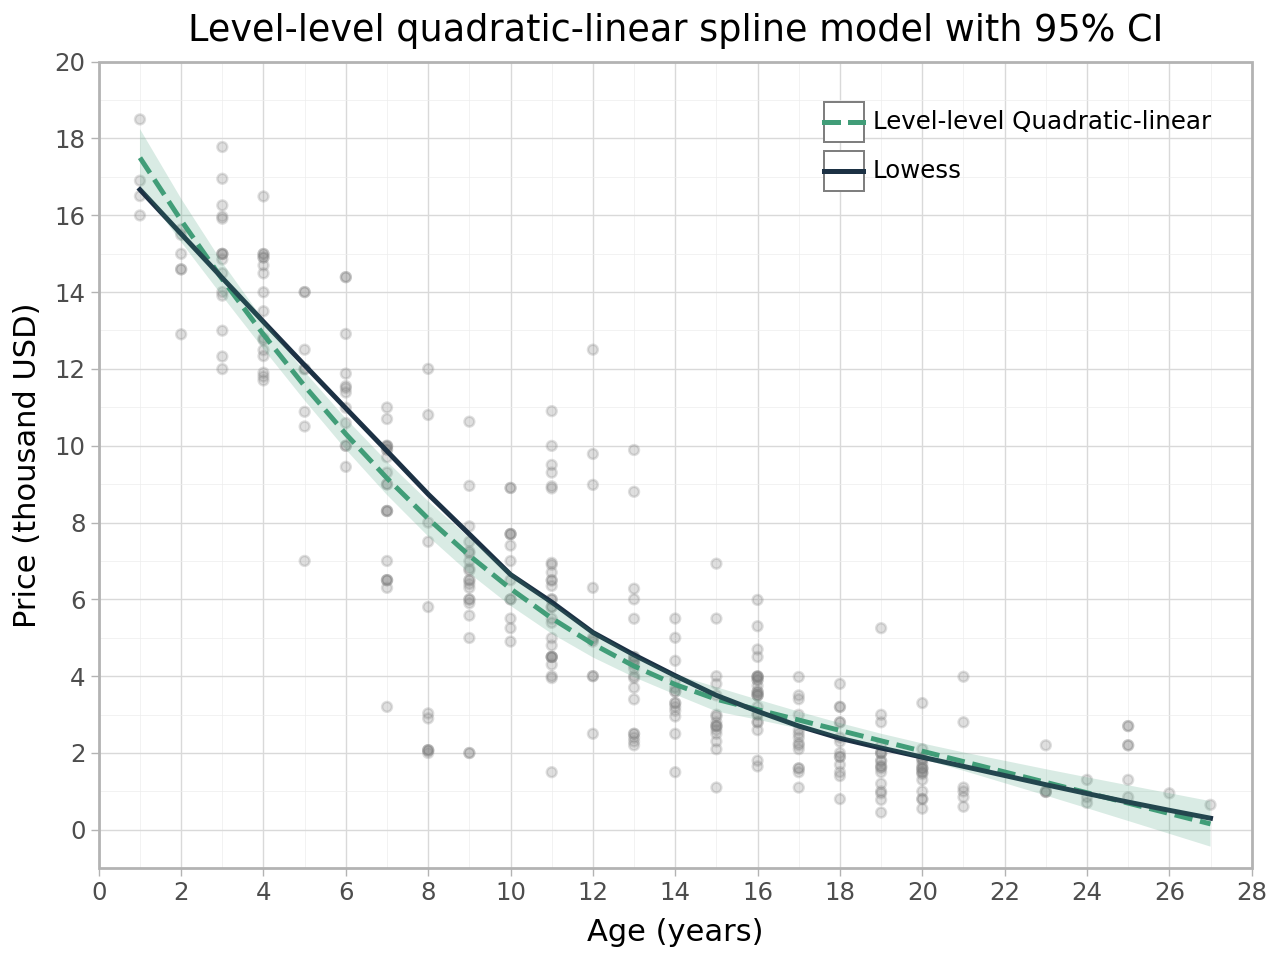

In [144]:
(
    ggplot(df_best.melt(id_vars='age', value_vars=['best', 'lowess'])
          .rename(columns={'variable': 'model', 'value': 'price'}))
    + geom_point(
        aes(x='age', y='price'),
        data=chicago,
        color='grey',
        alpha=0.25
    )
    + geom_line(aes(x='age', y='price', color='model', linetype='model'),size=1)
    + geom_ribbon(
        aes(ymin='best_cilo', ymax='best_ciup', x = 'age'),
        data = df_best,
        fill='#419D78',
        alpha=0.2,
    )
    + scale_color_manual(
        values=['#419D78', '#1C3144'],
        labels=['Level-level Quadratic-linear', 'Lowess']
    )
    + scale_linetype_manual(
        values=['--', '-'],
        labels=['Level-level Quadratic-linear', 'Lowess']
    )
    + scale_x_continuous(expand=(0, 0),
                         limits=(0, 28),
                         breaks=np.arange(0, 29, 2)
                        )
    + scale_y_continuous(expand=(0, 0),
                         limits=(-1, 20),
                         breaks=np.arange(0, 21, 2)
                        )
    + theme_light()
    + theme(
        legend_position=(0.95, 0.95),
        legend_title=element_blank(),
        legend_background=element_blank()
    )
    + labs(
        x='Age (years)',
        y='Price (thousand USD)',
        title='Level-level quadratic-linear spline model with 95% CI'
    )
)


Let's compare the two previously mentioned models (that is, the level-level quadratic and PLS ones) with our new quadratic spline - linear spline model.

In [114]:
best_regs = []
best_regs.append(smf.ols(formula='price~age+age_sq',data=chicago).fit(cov_type = 'HC0'))
best_regs.append(smf.ols(formula='price~lspline(age,[10,15])',data=chicago).fit(cov_type = 'HC0'))
best_regs.append(best)

In [163]:
table2 = Stargazer(best_regs)
table2.custom_columns(['Level-level Quadratic','Level-level PLS','Level-level Quadratic-Linear'])
table2.rename_covariates(
    {
        'Intercept' : 'Constant',
        'age_sq' : 'age squared',
        'lspline(age, [10, 15])[0]': 'age spline < 10',
        'lspline(age, [10, 15])[1]' : 'age spline 10-15',
        'lspline(age, [10, 15])[2]' : 'age spline > 15',
        'linear_and_quadratic_design(age, 15)[0]': 'age spline < 15',
        'linear_and_quadratic_design(age, 15)[1]': 'age spline < 15 squared', 
        'linear_and_quadratic_design(age, 15)[2]': 'age linear spline > 15',
    }
)
table2.add_custom_notes(['Heteroscedasticity corrected standard errors used (HC0).'])

table2

In [167]:
np.mean(chicago.age)

12.31055900621118

First, let's interpret the models one by one! Note that all coefficients in all models are significant at 1%.

**Level-level Quadratic**

1. **Constant (18.336):**
   The intercept indicates that the average price of zero year old car in Chicago would be 18.3 thousand USD. Note that this practically does not make sense, as we are analysing used cars - and those are, by definition, older than 0 years.

2. **age (-1.521) and age squared (0.034):**  
   The coefficients of the age variables together indicate that when comparing cars with a year higher age, we can expect their price to be `-1.521 + 0.068 x age` thousand USD different on average. For a car one year older than the averagely old car in Chicago, this translates to a -0.7 thousand USD difference. Also, the positive coefficient of age squared shows that the fitted functional form in a convex parabola - that is, the average price difference between cars aged a year higher is getting smaller as the age progresses.

**Level-level PLS**

1. **Constant (17.807):**  
   The average price of 0-year-old used cars would be 17.8 thousand USD according to this model. Again, a 0-year-old used car does not make sense practically, so this is only hypothetical.

2. **age spline < 10 (-1.193):**  
   For cars aged less than 10 years, comparing two cars with one year difference in age, we can expect the price to be 1.2 thousand USD lower on average for the older car. 

3. **age spline 10-15 (-0.503):**  
   For cars aged between 10 and 15 years, comparing two cars with one year difference in age, we can expect the price to be 503 USD lower on average for the older car.

4. **age spline > 15 (-0.264):**  
   For cars aged over 15 years, comparing two cars with one year difference in age, we can expect the price to be 264 USD lower on average for the older car.

**Level-level Quadratic-Linear Spline**

1. **Constant (19.224):**  
   The intercept indicates that the average price of zero year old car in Chicago would be 19.2 thousand USD (but note our remarks above about the practicality of this interpretation).

2. **age spline < 15 (-1.774) and age spline < 15 squared (0.048):**  
   For cars aged under 15 years, comparing two cars with one year difference in age, we can expect the price to be `-1.774 + 0.096 x age` different on average for the older car. For a car one year older than the averagely old car in Chicago, this translates to a -592 USD difference. Also, the positive coefficient of age squared shows that the fitted functional form in a convex parabola - that is, the average price difference between cars aged a year higher is getting smaller as the age progresses.

4. **age linear spline > 15 (-0.270):**  
   For cars aged over 15 years, comparing two cars with one year difference in age, we can expect the price to be 270 USD lower on average for the older car.


To further provide some insights into which model performs the best, we have presented below the values of the most common information criteria together with R-squared and adjusted R-squared values.

In [231]:
information_criteria = []
models = ['Quadratic', 'PLS', 'Quad.-Lin. Spline']
for i, reg in enumerate(best_regs):
    metrics = {
        "Model": models[i],
        "BIC": reg.bic,
        "AIC": reg.aic,
        "R-squared": reg.rsquared,
        "Adj. R-squared": reg.rsquared_adj
    }
    information_criteria.append(metrics)
information_criteria_df = pd.DataFrame(information_criteria).set_index('Model')
information_criteria_df.T.applymap(lambda x: format(x, '.4f'))

Model,Quadratic,PLS,Quad.-Lin. Spline
BIC,1322.1291,1330.1348,1325.6523
AIC,1310.8054,1315.0366,1310.5541
R-squared,0.8336,0.8324,0.8348
Adj. R-squared,0.8326,0.8309,0.8332


As we can see, there is no straightforward decision on which model performs the best:
- according to BIC, we should choose the quadratic one;
- according to AIC, the quadratic-linear spline is better;
- also, the quadratic linear-spline is better in R-squared and adjusted R-squared.

So, our model choice depends on what we value more: simplicity or a slightly better fit. In our opinion, as the sample is relatively small, we should value simplicity over a slightly better fit. Thus, we deem the level-level quadratic model the best.

Now let's move on to external validity. Even though we have argued that the best model is the level-level quadratic one, we still present an external validity check for the other two models as well (just as an exercise). In the external validity tests, we present the same model specifications, computed in the Chicago and the LA subsamples.

In [177]:
chicago_reg = smf.ols(formula='price~age+age_sq',data=chicago).fit(cov_type = 'HC0')
la_reg = smf.ols(formula='price~age+age_sq',data=la).fit(cov_type = 'HC0')
chicago_reg2 = smf.ols(formula='price~lspline(age,[10,15])',data=chicago).fit(cov_type = 'HC0')
la_reg2 = smf.ols(formula='price~lspline(age,[10,15])',data=la).fit(cov_type = 'HC0')
chicago_reg3 = smf.ols(formula='price~linear_and_quadratic_design(age,15)',data=chicago).fit(cov_type = 'HC0')
la_reg3 = smf.ols(formula='price~linear_and_quadratic_design(age,15)',data=la).fit(cov_type = 'HC0')

In [198]:
external_table = Stargazer([chicago_reg, la_reg, chicago_reg2, la_reg2, chicago_reg3, la_reg3])
external_table.custom_columns(['Chicago Quad.', 'LA Quad.', 'Chicago PLS', 'LA PLS', 'Chicago Quad.-lin.', 'LA Quad.-lin.'])
external_table.rename_covariates(
    {
        'Intercept' : 'Constant',
        'lspline(age, [10, 15])[0]': 'age spline < 10',
        'lspline(age, [10, 15])[1]' : 'age spline 10-15',
        'lspline(age, [10, 15])[2]' : 'age spline > 15',
        'age_sq' : 'age squared',
        'linear_and_quadratic_design(age, 15)[0]' : 'age spline < 15',
        'linear_and_quadratic_design(age, 15)[1]' : 'age spline < 15 squared',
        'linear_and_quadratic_design(age, 15)[2]' : 'age spline > 15'
    }
)
external_table.covariate_order(['Intercept', 'age', 'age_sq', 'lspline(age, [10, 15])[0]', 'lspline(age, [10, 15])[1]',
                                'linear_and_quadratic_design(age, 15)[0]','linear_and_quadratic_design(age, 15)[1]',
                                'lspline(age, [10, 15])[2]',
                                'linear_and_quadratic_design(age, 15)[2]'])

external_table.add_custom_notes(['Heteroscedasticity corrected standard errors used (HC0).'])
external_table

We can see some interesting things in the comparison table: for all of the models, the R-squared values of the LA models are quite low, and the coefficient estimates differ quite a lot from the Chicago models. What could be the reason for this?

Let's check the scatter plot of the LA subsample.

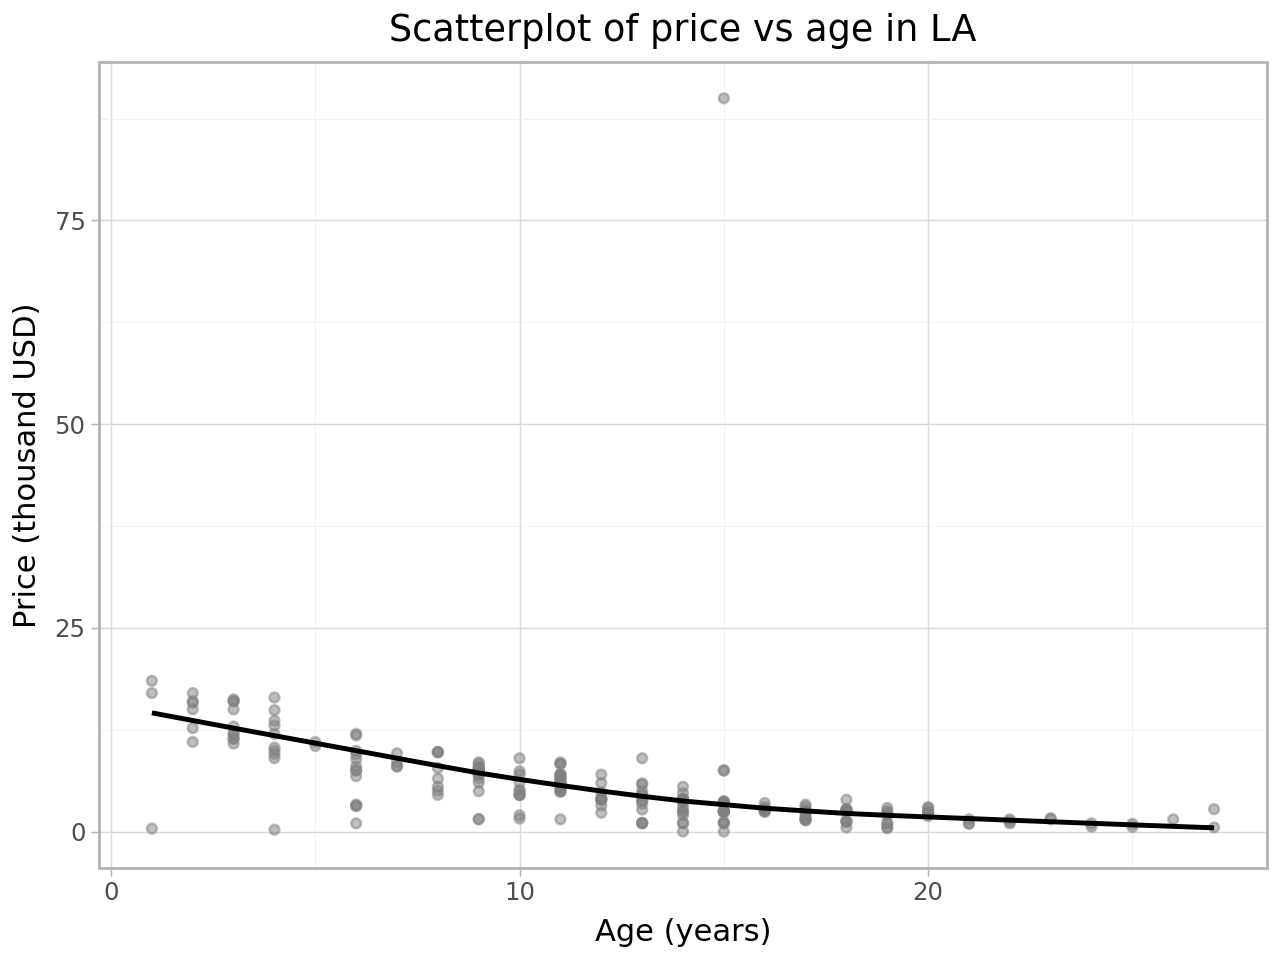

In [202]:
(
    ggplot(la)
    + aes(x = 'age', y = 'price')
    + geom_point(color = 'grey', alpha = 0.5)
    + geom_smooth(method = 'lowess', size = 1, color = 'black')
    + theme_light()
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Scatterplot of price vs age in LA')
)

As we take a look at the scatterplot for LA, we can see the reason of the differences: LA has similar outliers in the lower left corner as Chicago. Additionally in LA, there is an extremely highly priced car, and also some that are listed for 1 USD only. If we get rid of these, we can run the regressions again.

Before dropping these, we should inspect again the raw data to decide whether these are errors or sensible observations. Just like for Chicago, we can see that there is no sensible justification for the price of these cars given their age, so we are better off dropping them.

In [204]:
raw[((raw['price'] > 25) | ((raw['age'] < 10) & (raw['price'] < 1)) | (raw['price'] <= 0.001)) & (raw['area'] == 'los angeles')].T

,434,442,457,542,544
pricestr,$90002,$1,$226,$361,$1
area,los angeles,los angeles,los angeles,los angeles,los angeles
subarea,San Fernando,San Fernando,San Fernando,LA westside-southbay,North LA county
name,2003 Toyota Camry Xle,2003 toyota camry le,2014 Toyota Camry LE,2017 toyota camry hybrid,2004 toyota camry
condition,NaN,excellent,NaN,new,like new
cylinders,NaN,4 cylinders,4 cylinders,4 cylinders,NaN
drive,NaN,NaN,fwd,rwd,NaN
fuel,gas,gas,gas,hybrid,gas
odometer,14.081672,14.081672,2.8122,0.07,11.3
paintcolor,NaN,white,NaN,red,NaN


In [206]:
la = (la[~(la['price'] > 25)])
la = (la[~((la['age'] < 10) & (la['price'] < 1))])
la = (la[~(la['price'] <= 0.001)])

After dropping the outliers let's see how our scatter plot changed

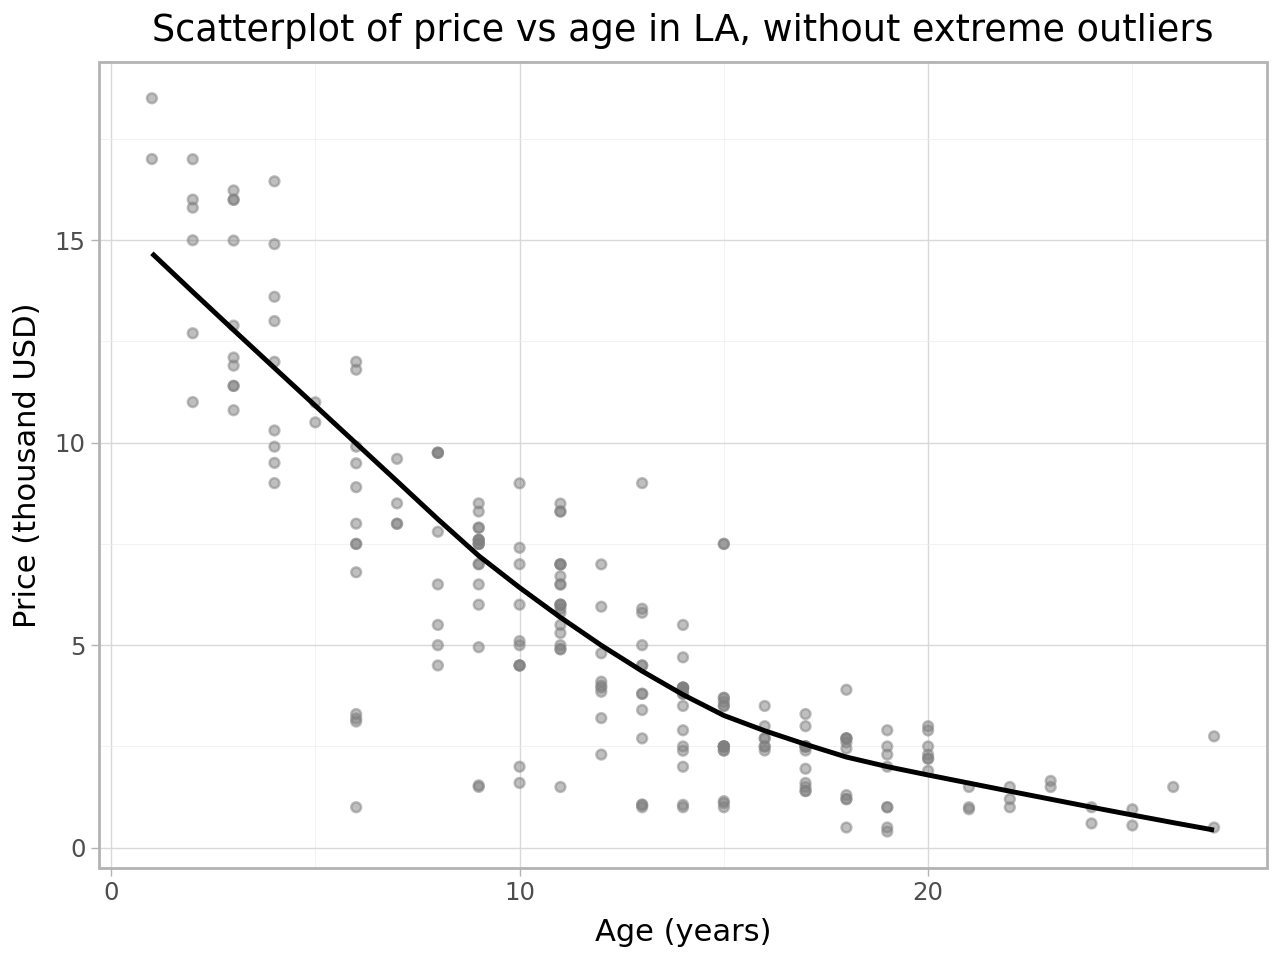

In [208]:
(
    ggplot(la)
    + aes(x = 'age', y = 'price')
    + geom_point(color = 'grey', alpha = 0.5)
    + geom_smooth(method = 'lowess', size = 1, color = 'black')
    + theme_light()
    + labs(x = 'Age (years)', y = 'Price (thousand USD)', title = 'Scatterplot of price vs age in LA, without extreme outliers')
)

Let's check the external validity again on the cleaned LA subsample.

In [210]:
chicago_reg = smf.ols(formula='price~age+age_sq',data=chicago).fit(cov_type = 'HC0')
la_reg = smf.ols(formula='price~age+age_sq',data=la).fit(cov_type = 'HC0')
chicago_reg2 = smf.ols(formula='price~lspline(age,[10,15])',data=chicago).fit(cov_type = 'HC0')
la_reg2 = smf.ols(formula='price~lspline(age,[10,15])',data=la).fit(cov_type = 'HC0')
chicago_reg3 = smf.ols(formula='price~linear_and_quadratic_design(age,15)',data=chicago).fit(cov_type = 'HC0')
la_reg3 = smf.ols(formula='price~linear_and_quadratic_design(age,15)',data=la).fit(cov_type = 'HC0')

In [212]:
external_table = Stargazer([chicago_reg, la_reg, chicago_reg2, la_reg2, chicago_reg3, la_reg3])
external_table.custom_columns(['Chicago Quad.', 'LA Quad.', 'Chicago PLS', 'LA PLS', 'Chicago Quad.-lin.', 'LA Quad.-lin.'])
external_table.rename_covariates(
    {
        'Intercept' : 'Constant',
        'lspline(age, [10, 15])[0]': 'age spline < 10',
        'lspline(age, [10, 15])[1]' : 'age spline 10-15',
        'lspline(age, [10, 15])[2]' : 'age spline > 15',
        'age_sq' : 'age squared',
        'linear_and_quadratic_design(age, 15)[0]' : 'age spline < 15',
        'linear_and_quadratic_design(age, 15)[1]' : 'age spline < 15 squared',
        'linear_and_quadratic_design(age, 15)[2]' : 'age spline > 15'
    }
)
external_table.covariate_order(['Intercept', 'age', 'age_sq', 'lspline(age, [10, 15])[0]', 'lspline(age, [10, 15])[1]',
                                'linear_and_quadratic_design(age, 15)[0]','linear_and_quadratic_design(age, 15)[1]',
                                'lspline(age, [10, 15])[2]',
                                'linear_and_quadratic_design(age, 15)[2]'])
external_table.add_custom_notes(['Heteroscedasticity corrected standard errors used (HC0).'])
external_table

With the cleaned LA subsample, external validity seems much better. We can see the following things:

- R-squared values are somewhat lower for LA (around 78%) compared to Chicago (around 83%);
- we can see that the constant terms tend to be lower for the LA models, meaning that the average price of 0-year-old cars tend to be lower in LA (by 1-1.5 thousand USD);
- the other parameter estimates seem quite similar in magnitude, with only a few hundred USD difference at maximum in average price difference between cars that are different by 1 year in age;
- all in all, the coefficients in the LA models are significant at 1%, meaning that the functional forms developed for Chicago hold well for LA as well.

From the above observations, we can conclude that external validity of the Chicago models for LA is relatively large. However, to formally asess external validity (that is, to test statistically whether the parameter estimates are different) we would need to run:
- either a pooled regression with a dummy for one of the cities;
- or use bootstrapping to get SE(beta_CH - beta_LA)

This is, however, outside the scope of this assignment. One thing, however, we can do, is to calculate the 95% confidence intervals for the parameters to see if they overlap. We only do this for our chosen model, that is the level-level quadratic one.

In [255]:
chicago_summary = chicago_reg.summary2().tables[1]
chicago_data = chicago_summary[['Coef.', '[0.025', '0.975]']].rename(columns={
    'Coef.': 'Chicago estimate',
    '[0.025': 'Chicago lower CI',
    '0.975]': 'Chicago upper CI'
})
la_summary = la_reg.summary2().tables[1]
la_data = la_summary[['Coef.', '[0.025', '0.975]']].rename(columns={
    'Coef.': 'LA estimate',
    '[0.025': 'LA lower CI',
    '0.975]': 'LA upper CI'
})
combined_data = pd.concat([chicago_data, la_data], axis=1)
combined_data['Overlap'] = combined_data.apply((lambda row: not (row['Chicago upper CI'] < row['LA lower CI'] or row['LA upper CI'] < row['Chicago lower CI'])), axis=1)
combined_data = combined_data.filter(['Chicago estimate', 'LA estimate', 'Chicago lower CI', 'Chicago upper CI', 'LA lower CI', 'LA upper CI', 'Overlap'])
combined_data.rename(index={
    'Intercept' : 'Constant',
    'age' : 'age',
    'age_sq' : 'age squared'
})

,Chicago estimate,LA estimate,Chicago lower CI,Chicago upper CI,LA lower CI,LA upper CI,Overlap
Constant,18.335843,16.662392,17.676293,18.995393,15.483277,17.841507,True
age,-1.521104,-1.393843,-1.630145,-1.412062,-1.558529,-1.229157,True
age squared,0.034488,0.031899,0.030354,0.038623,0.026393,0.037406,True
